# Clustering drills

Welcome, traveller, you have arrived in the drills section of the clustering chapter. Here, you can practice some clustering techniques.

If you have not checked out the [example](./1.clustering_with_sklearn.ipynb), I advise you do so. We will use the same [pokemon](./assets/pokemon.csv) dataset to further our journey.

## 1. Multi-dimensional data

in the example, we wanted to determine the **most physically diverse** [pokemon](./assets/pokemon.csv) team there is. To do so, we clustered the pokemon into groups according to their **weight** and **height** using **k-means**.

Is this really the most diverse team out there though? The pokemon selected there are still similar in terms of **combat abilities**, and we have this data available.

For the first drill, I want you to:
   - cluster the pokemon into 6 groups according to similar:
       - height
       - weight
       - hp
       - attack
       - defense
       - speed
   - visualise these multidimensional clusters using a scatter plot matrix
   - determine the most dissimilar pokemon team from these clusters
   
So that you have **6-dimensional** clusters containing **diverse** pokemon groups from which you can determine your pokemon team similar to the method described in the example.

In [2]:
import pandas as pd
pokemon = pd.read_csv("./assets/pokemon.csv")
pd.set_option('display.max_rows', 800)

In [3]:
pokemon[['height_m','weight_kg','hp','attack','defense','speed']]
print(pokemon['weight_kg'].isnull().sum())
print(pokemon['height_m'].isnull().sum())
print(pokemon['hp'].isnull().sum())
print(pokemon['attack'].isnull().sum())
print(pokemon['defense'].isnull().sum())
print(pokemon['speed'].isnull().sum())

20
20
0
0
0
0


In [4]:
pokemon['type1'].unique()

array(['grass', 'fire', 'water', 'bug', 'normal', 'poison', 'electric',
       'ground', 'fairy', 'fighting', 'psychic', 'rock', 'ghost', 'ice',
       'dragon', 'dark', 'steel', 'flying'], dtype=object)

In [5]:
pokemon['type2'].unique()

array(['poison', nan, 'flying', 'dark', 'electric', 'ice', 'ground',
       'fairy', 'grass', 'fighting', 'psychic', 'steel', 'fire', 'rock',
       'water', 'dragon', 'ghost', 'bug', 'normal'], dtype=object)

In [6]:
pokemon['type2'].value_counts(dropna=False)

NaN         384
flying       95
poison       34
ground       34
psychic      29
fairy        29
fighting     25
steel        22
dark         21
grass        20
water        17
dragon       17
ice          15
rock         14
ghost        14
fire         13
electric      9
bug           5
normal        4
Name: type2, dtype: int64

In [7]:
# drop rows containing null values for weight or height
pokemon = pokemon.dropna(axis=0, subset=['weight_kg'])
pokemon = pokemon.dropna(axis=0, subset=['height_m']) 

# adjusting index
pokemon = pokemon.reset_index(drop=True)

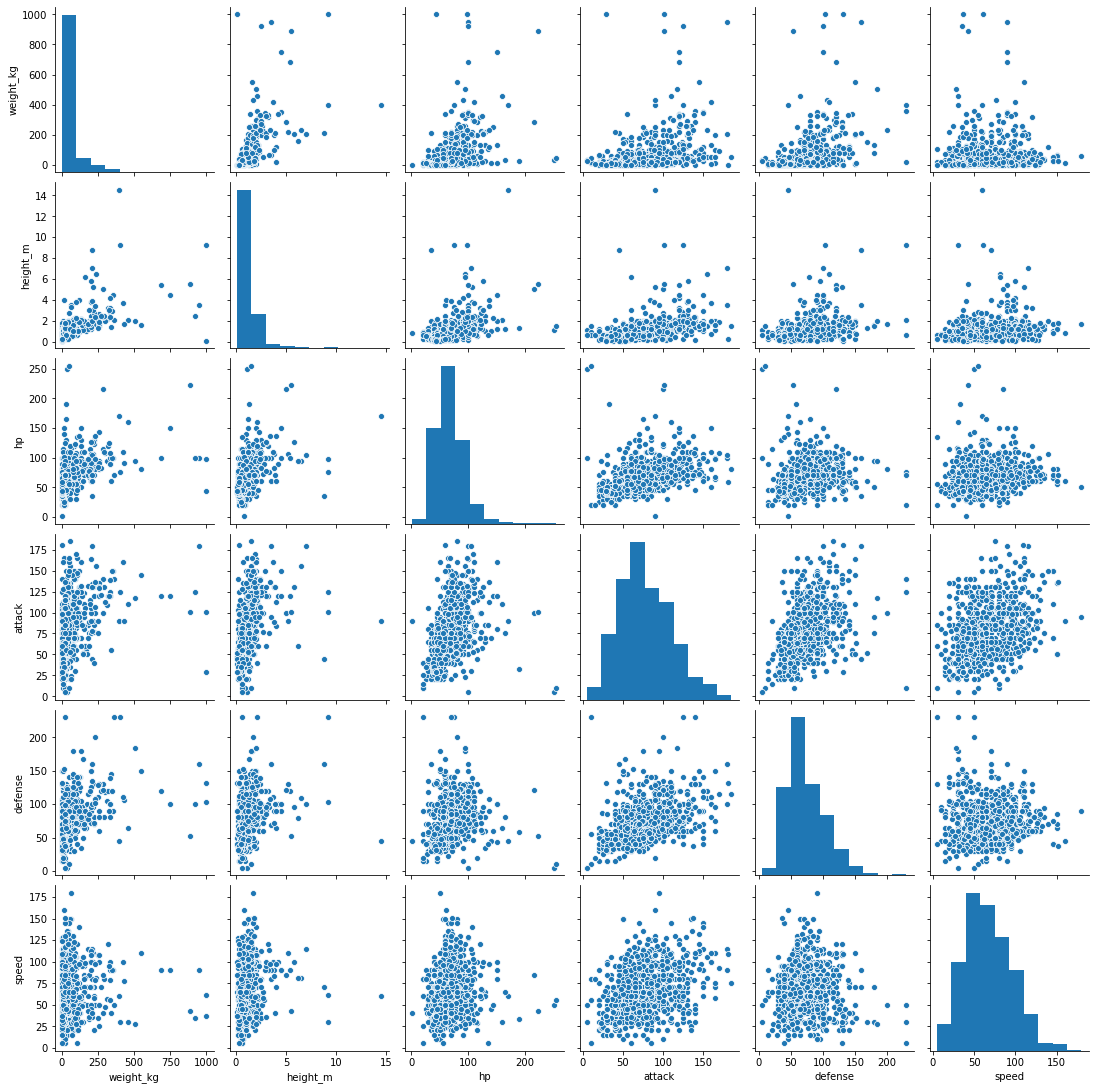

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data=pokemon,vars=['weight_kg','height_m','hp','attack','defense','speed'])

# plot size metrics
# fig=plt.figure(figsize=(10,10))
# plt.scatter( pokemon['hp'], pokemon['attack'], s=2)
# plt.title("pokémon size metrics")
# plt.xlabel("pokémon weight [kg]")
# plt.ylabel("pokémon height [m]")

In [9]:
# cluster your pokemon here

from sklearn.cluster import KMeans

# number of pokemon clusters
team_size = 6

# make new dataframe with relevant metrics
#pokemon[['weight_kg', 'height_m','hp','attack','defense','speed']]
pokemon_metrics = pokemon['weight_kg'].to_frame().join(pokemon['height_m'].to_frame()).join(pokemon['hp'].to_frame()).join(pokemon['attack'].to_frame()).join(pokemon['defense'].to_frame()).join(pokemon['speed'].to_frame())

# z-score normalisation
pokemon_metrics_normalized=(pokemon_metrics-pokemon_metrics.mean())/pokemon_metrics.std()
pokemon_metrics_normalized = pokemon_metrics_normalized.rename(columns={'weight_kg': 'weight_zscore',
                                                                        'height_m':'height_zscore',
                                                                        'hp':'hp_zscore',
                                                                        'attack':'attack_zscore',
                                                                        'defense':'defense_zscore',
                                                                        'speed':'speed_zscore'})
# fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=team_size, init='k-means++').fit(pokemon_metrics_normalized)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
pokemon_metrics_normalized = pokemon_metrics_normalized.join(cluster_labels.to_frame())


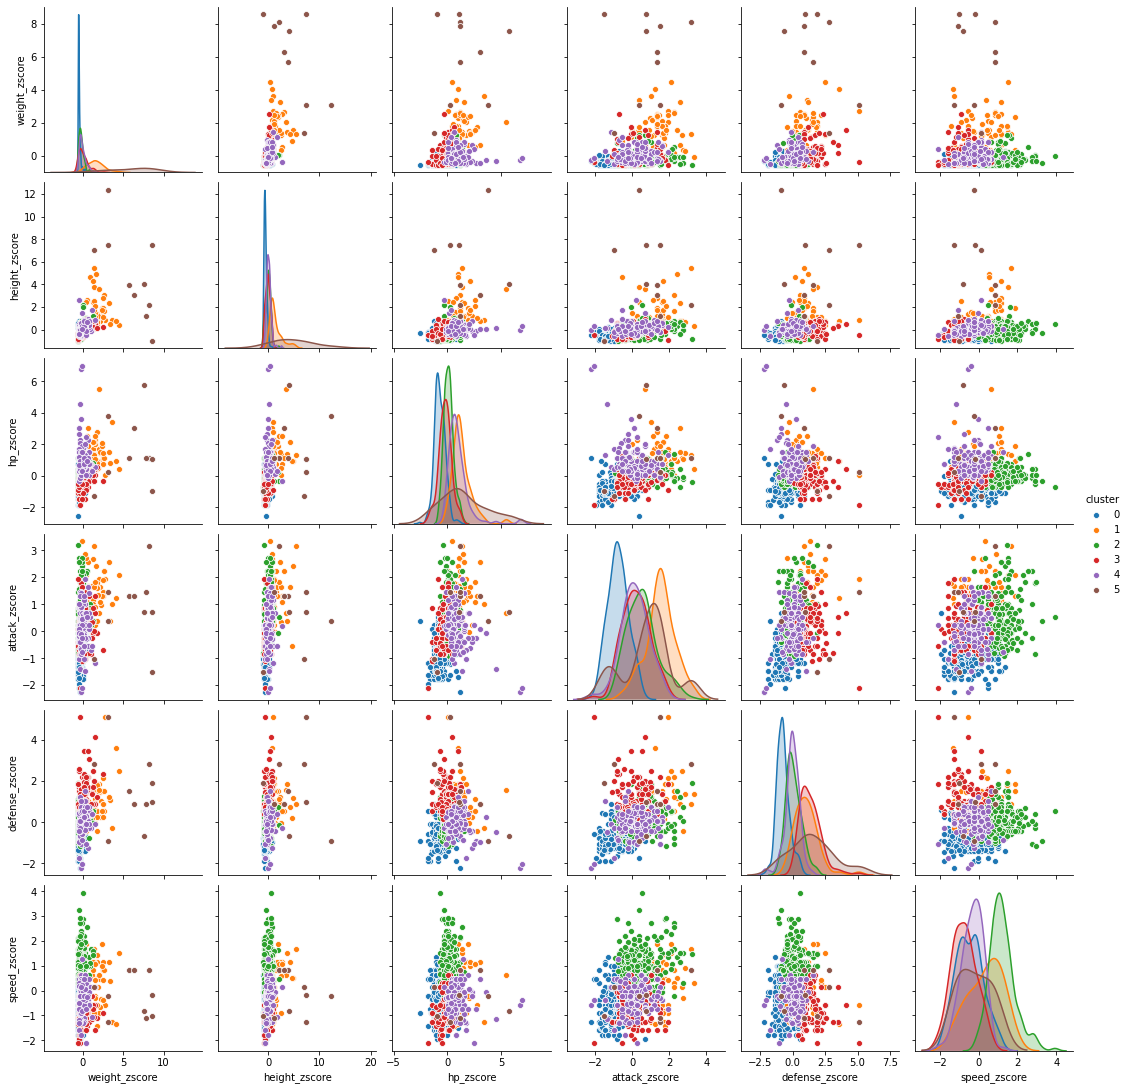

In [10]:
# visualise your clusters here (take a look at the pandas scatter_matrix or seaborn's pairplot method)
import seaborn as sns
#sns.pairplot(x='weight_zscore', y='height_zscore',  height=10, data=pokemon_metrics_normalized, fit_reg=False, hue='cluster')
sns.pairplot(data=pokemon_metrics_normalized,vars=['weight_zscore','height_zscore','hp_zscore','attack_zscore','defense_zscore','speed_zscore'], hue='cluster')

In [11]:
# determine your final pokemon here

In [12]:
import numpy as np
def euclidean_distance (metric, center):
    distance = np.sqrt(sum(np.square(metric - center))) #euclidean
    return distance
def distance_to_other_clusters(pokemon):
    if not pokemon.loc[pokemon.isin(['weight_zscore','height_zscore','hp_zscore','attack_zscore','defense_zscore','speed_zscore','cluster'])].all():
        return
    metric = np.array([pokemon['weight_zscore'], pokemon['height_zscore'],pokemon['hp_zscore'], pokemon['attack_zscore'],pokemon['defense_zscore'], pokemon['speed_zscore']])
    cluster_number = round(pokemon['cluster'])
    distance = 0
    for cluster_index in range(0, len(cluster_centers)):
        if cluster_index == cluster_number:
            continue
        center = cluster_centers[cluster_index]
        distance += np.sqrt(sum(np.square(metric - center))) #euclidean
        #distance += sum(metric - center) #manhattan distance
        #distance += sum(np.square(metric - center)) #squared distance
        #distance += 1/sum(np.square(metric - center)) #1/(squared distance)
        
        
        #distance += distance_func(metric, center)
    return distance

# evaluate all pokemon
pokemon_dissimilarity = pokemon_metrics_normalized.apply(distance_to_other_clusters, axis=1)
pokemon_dissimilarity = pokemon_dissimilarity.rename('dissimilarity')

# join to other metrics
pokemon_processed = pokemon_metrics_normalized.join(pokemon_dissimilarity.to_frame()).join(pokemon['name'].to_frame())

# pick most dissimilar pokemon per cluster
chosen_pokemon = pd.DataFrame()
for cluster_index in range(0, len(cluster_centers)):
   pokemon_cluster = pokemon_processed[pokemon_processed['cluster'] == cluster_index]
   chosen_pokemon = chosen_pokemon.append(pokemon_cluster[pokemon_cluster['dissimilarity']==pokemon_cluster['dissimilarity'].max()])

In [13]:
chosen_pokemon


,weight_zscore,height_zscore,hp_zscore,attack_zscore,defense_zscore,speed_zscore,cluster,dissimilarity,name
330,-0.493605,-0.521965,-1.846184,-1.945584,-1.720527,0.474702,0,28.474812,Feebas
699,2.041264,3.550879,5.516236,0.692223,1.558054,0.647687,1,34.665070,Zygarde
367,-0.005287,0.496246,-0.719283,0.537058,0.551757,3.934406,2,27.876057,Deoxys
194,-0.373812,-0.521965,-1.846184,-2.100749,5.096325,-2.120077,3,37.373853,Shuckle
94,-0.244874,-0.059142,6.793391,-2.255914,-2.207445,-0.563210,4,42.368550,Chansey
302,3.078255,12.344519,3.788321,0.381893,-0.908997,-0.217239,5,65.365991,Wailord



## 2. Similarity criteria

Very nice! What a unique team!

You probably used the same **similarity criteria** as the introduction example. **k-means** uses Euclidean distance as a similarity criteria, so it makes sense that we also use Euclidean distance for our **dissimilarity criteria**, but what would happen if we picked something else?

"Woah, you're going too fast, 'Euclidean distance'? What do you mean by that?"

This is distance as we know it in the **real world**, a line connecting two points. But distance does not have to be defined this way in our **problem space**, it can be **Manhattan distance**, or **squared distance**, or something else entirely.

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-981-10-8818-6_7/MediaObjects/463464_1_En_7_Fig2_HTML.jpg" align="center" width="600"/>

Replacing this similarity criteria for the `sklearn` k-means is no trivial task, so I will not ask this of you, but changing it for our **dissimilarity criteria** should be doable.

For the next exercise, I would like you to:
- replace the dissimilarity criteria from the example by:
    - manhattan distance
    - squared distance
    - 1/(squared distance)

In [14]:
# Assign dissimilarity to your pokemon here

In [17]:
import numpy as np 

def distance_to_other_clusters(pokemon):
#     if not pokemon.loc[pokemon.isin(['weight_zscore','height_zscore','hp_zscore','attack_zscore','defense_zscore','speed_zscore','cluster'])].all():
#         return
    metric = np.array([pokemon['weight_zscore'], pokemon['height_zscore'],pokemon['hp_zscore'], pokemon['attack_zscore'],pokemon['defense_zscore'], pokemon['speed_zscore']])
    cluster_number = round(pokemon['cluster'])
    distance = 0
    for cluster_index in range(0, len(cluster_centers)):
        if cluster_index == cluster_number:
            continue
        center = cluster_centers[cluster_index]
        distance += sum(abs(metric - center)) #MANHATTAN
    return distance

# evaluate all pokemon
pokemon_dissimilarity = pokemon_metrics_normalized.apply(distance_to_other_clusters, axis=1)
pokemon_dissimilarity = pokemon_dissimilarity.rename('dissimilarity')

# join to other metrics
pokemon_processed = pokemon_metrics_normalized.join(pokemon_dissimilarity.to_frame()).join(pokemon['name'].to_frame())

# pick most dissimilar pokemon per cluster
chosen_pokemon = pd.DataFrame()
for cluster_index in range(0, len(cluster_centers)):
   pokemon_cluster = pokemon_processed[pokemon_processed['cluster'] == cluster_index]
   chosen_pokemon = chosen_pokemon.append(pokemon_cluster[pokemon_cluster['dissimilarity']==pokemon_cluster['dissimilarity'].max()])

In [18]:
chosen_pokemon

,weight_zscore,height_zscore,hp_zscore,attack_zscore,defense_zscore,speed_zscore,cluster,dissimilarity,name
330,-0.493605,-0.521965,-1.846184,-1.945584,-1.720527,0.474702,0,61.263083,Feebas
699,2.041264,3.550879,5.516236,0.692223,1.558054,0.647687,1,67.454243,Zygarde
777,-0.560361,-0.799659,-0.381213,3.205898,1.882666,1.478016,2,54.624357,Kartana
194,-0.373812,-0.521965,-1.846184,-2.100749,5.096325,-2.120077,3,77.632323,Shuckle
94,-0.244874,-0.059142,6.793391,-2.255914,-2.207445,-0.563210,4,78.960109,Chansey
302,3.078255,12.344519,3.788321,0.381893,-0.908997,-0.217239,5,104.261984,Wailord


Did your team change? Why do you think it did(n't)? Discuss this with one of your colleagues!

## 3. Heterogenous data

There! We did it! The most **diverse pokémon team** possible...or is it?

We have clustered our pokémon according to **weight** and **height** in the example, and according to **combat abilities** in the first drill, but what about **pokémon type**?

Some of the chosen pokémon may have the same type, as this data was ignored during clustering? But to get a really diverse team, we should take these into account!

For this drill I want you to:
- cluster the pokémon into 6 groups according to similar:
    - weight
    - height
    - primary pokémon type
    - secondary pokémon type
- determine the most dissimilar pokemon team from these clusters

But wait, these pokémon types, they're in **text format**, how do you compare these to the **numerical data**? It's time to **vectorize** this data. **Vectorizing** this textual data means representing this data in a way that can be understood by machine learning algorithms. 

For example, let's say there are only 3 pokémon types, and pokémon can only have one type. Vectorising a **grass**, **fire**, and **water** pokémon would look like this:
- grass -> [1, 0, 0]
- fire  -> [0, 1, 0]
- water -> [0, 0, 1]

So in this case, **3-dimensional** data. In our case though, we have a weight dimension, a height dimension, 18 primary and secondary type dimensions, so a whopping **38 dimensions**

In [ ]:
# vectorize your pokémon type data here (there are modules that vectorize data)

In [19]:
one_hot_type1 = pd.get_dummies(pokemon['type1'])
one_hot_type2 = pd.get_dummies(pokemon['type2'])


In [47]:
one_hot_type2.head(5)


,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
one_hot_type2.shape

(781, 18)

In [22]:
pokemon.shape

(781, 41)

In [35]:
#pokemon_types = pokemon[['weight_zscore','height_zscore']].join(one_hot_type1.to_frame())
pokemon_types = pd.merge(one_hot_type1, one_hot_type2, left_index=True, right_index=True, suffixes=('_t1', '_t2'))


In [42]:
pokemon.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

In [48]:
pokemon_hot_encoded = pokemon[['weight_kg','height_m']].join(pokemon_types)
pokemon_hot_encoded.head(20)
pokemon_hot_encoded.columns

Index(['weight_kg', 'height_m', 'bug_t1', 'dark_t1', 'dragon_t1',
       'electric_t1', 'fairy_t1', 'fighting_t1', 'fire_t1', 'flying_t1',
       'ghost_t1', 'grass_t1', 'ground_t1', 'ice_t1', 'normal_t1', 'poison_t1',
       'psychic_t1', 'rock_t1', 'steel_t1', 'water_t1', 'bug_t2', 'dark_t2',
       'dragon_t2', 'electric_t2', 'fairy_t2', 'fighting_t2', 'fire_t2',
       'flying_t2', 'ghost_t2', 'grass_t2', 'ground_t2', 'ice_t2', 'normal_t2',
       'poison_t2', 'psychic_t2', 'rock_t2', 'steel_t2', 'water_t2'],
      dtype='object')

In [ ]:
# cluster your multi-dimensional pokémon data here

In [77]:
# cluster your pokemon here
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

# number of pokemon clusters
team_size = 6

# make new dataframe with relevant metrics
pokemon_metrics = pokemon_hot_encoded.copy()
#pokemon_metrics = pokemon['weight_kg'].to_frame().join(pokemon['height_m'].to_frame()).join(pokemon['hp'].to_frame()).join(pokemon['attack'].to_frame()).join(pokemon['defense'].to_frame()).join(pokemon['speed'].to_frame())

# z-score standardization
pokemon_metrics_standardized=(pokemon_metrics-pokemon_metrics.mean())/pokemon_metrics.std() #############################

# # fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=team_size, init='k-means++').fit(pokemon_metrics_standardized)
 

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
pokemon_metrics_standardized = pokemon_metrics_standardized.join(cluster_labels.to_frame())
pokemon_metrics_standardized['cluster'].value_counts()

1    449
3    101
2     77
4     72
5     52
0     30
Name: cluster, dtype: int64

In [78]:
from sklearn.metrics import silhouette_score
silhouette_score(pokemon_metrics_standardized, cluster_labels)

0.08167292998799192

In [56]:
# determine your unique team here
import numpy as np

def distance_to_other_clusters(pokemon):
#         if not pokemon.loc[pokemon.isin(['weight_zscore','height_zscore','hp_zscore','attack_zscore','defense_zscore','speed_zscore','cluster'])].all():
#             return
#     metric = np.array([pokemon['weight_zscore'], pokemon['height_zscore'],pokemon['hp_zscore'], pokemon['attack_zscore'],pokemon['defense_zscore'], pokemon['speed_zscore']])
    metric = pokemon.drop(labels='cluster').to_numpy()
    cluster_number = round(pokemon['cluster'])
    distance = 0
    for cluster_index in range(0, len(cluster_centers)):
        if cluster_index == cluster_number:
            continue
        center = cluster_centers[cluster_index]
        distance += np.sqrt(sum(np.square(metric - center))) #euclidean
        #distance += sum(metric - center) #manhattan distance
        #distance += sum(np.square(metric - center)) #squared distance
        #distance += 1/sum(np.square(metric - center)) #1/(squared distance)
        
        
        #distance += distance_func(metric, center)
    return distance

# evaluate all pokemon
pokemon_dissimilarity = pokemon_metrics_standardized.apply(distance_to_other_clusters, axis=1)

pokemon_dissimilarity = pokemon_dissimilarity.rename('dissimilarity')

# join to other metrics
pokemon_processed = pokemon_metrics_standardized.join(pokemon_dissimilarity.to_frame()).join(pokemon['name'].to_frame())

# pick most dissimilar pokemon per cluster
chosen_pokemon = pd.DataFrame()
for cluster_index in range(0, len(cluster_centers)):
   pokemon_cluster = pokemon_processed[pokemon_processed['cluster'] == cluster_index]
   chosen_pokemon = chosen_pokemon.append(pokemon_cluster[pokemon_cluster['dissimilarity']==pokemon_cluster['dissimilarity'].max()])

In [57]:
chosen_pokemon

,weight_kg,height_m,bug_t1,dark_t1,dragon_t1,electric_t1,fairy_t1,fighting_t1,fire_t1,flying_t1,...,ice_t2,normal_t2,poison_t2,psychic_t2,rock_t2,steel_t2,water_t2,cluster,dissimilarity,name
576,-0.555788,-0.984788,3.136019,-0.196251,-0.189112,-0.226006,-0.153496,-0.192710,-0.261365,-0.062057,...,-0.119446,-0.071704,-0.206565,-0.19271,-0.135017,-0.170142,-0.149073,0,56.070809,Joltik
675,-0.506408,-0.614530,-0.318467,-0.196251,-0.189112,4.419004,-0.153496,-0.192710,-0.261365,-0.062057,...,-0.119446,13.928434,-0.206565,-0.19271,-0.135017,-0.170142,-0.149073,1,75.935524,Helioptile
720,1.084744,0.496246,-0.318467,-0.196251,-0.189112,-0.226006,-0.153496,5.182511,-0.261365,-0.062057,...,8.361242,-0.071704,-0.206565,-0.19271,-0.135017,-0.170142,-0.149073,2,53.205918,Crabominable
696,0.216012,0.311117,-0.318467,-0.196251,-0.189112,-0.226006,-0.153496,-0.192710,-0.261365,16.093517,...,-0.119446,-0.071704,-0.206565,-0.19271,-0.135017,-0.170142,-0.149073,3,90.156199,Noivern
759,1.130466,1.699586,-0.318467,-0.196251,-0.189112,-0.226006,-0.153496,-0.192710,-0.261365,-0.062057,...,-0.119446,-0.071704,-0.206565,-0.19271,-0.135017,-0.170142,-0.149073,4,43.367176,Drampa
441,0.677811,0.959069,-0.318467,-0.196251,-0.189112,-0.226006,-0.153496,-0.192710,-0.261365,-0.062057,...,8.361242,-0.071704,-0.206565,-0.19271,-0.135017,-0.170142,-0.149073,5,49.680818,Abomasnow


But wait, did you properly **normalize** your data? If you simply vectorize your data like in the example shown above, you might not get the results you want (try this for yourselves, what do you notice?).

The example normalizes its data using the **z-score**. What does this mean? z-score or mean normalization means we are using our **problem space** where our data lives optimally. 

in the case of the pokemon weight and height, it was clear to see the **order of magnitude** of the weight is larger than that of the height. During clustering, this would mean that **weight similarity would matter more than height similarity**, since the euclidian distance between points of data would be larger.

For example, A pokemon weighing 200kg and measuring 4m is about **as similar** as another pokémon weighing 100kg and measuring 2m in terms of both weight and height. But the euclidian difference in between the weight difference is 100(kg), while the difference of height is only 2(m). That is where normalization comes in handy. It scales these metrics so they can be compared fairly.

Which is why when we vectorize out **pokémon types** into vectors of length one, the **euclidian distance** between one pokémon type and the other is about 1.4 (thanks Pythagoras), which isn't that much compared to the weight and height difference.

Show me how you would **make sure** that **similarity or dissimilarity** of the **pokémon type** matters more than **weight or height**?

In [ ]:
# normalize and scale your data in such a way that pokémon type similarity matters more than the other metrics

## 4. Cluster method comparison

I hope you're getting a bit more comfortable with the **k-means** method, it sure is a popular one, but it's [not the only clustering technique](https://scikit-learn.org/stable/modules/clustering.html) out there!

For this excercise, I want you to:
- pick 3 clustering techniques from the `scikit-learn` library
- cluster the pokémon according weight and height
- try to adjust the cluster method arguments so 6 clusters are obtained after clustering
- evaluate in-cluster similarity and cluster-to-cluster similarity:
  - compare every pokémon in a cluster to every other pokémon within that same cluster (choose your own similarity criteria)
  - take the average of these in-cluster similarities
  - do this for every cluster
  - take the the average or centroid of ever cluster, and determine the similarity to every other cluster
  - compare these two metrics (in-cluster similarity and cluster-to-cluster similarity) for every chosen clustering technique
  - determine the 'best' technique by maximising in-cluster similarity and minimizing cluster-to-cluster similarity
- visualize the results

Bonus: track these metrics for every iteration of the algorithms and plot the progression from start to finish

In [ ]:
# compare your techniques here

### SpectralClustering

In [80]:
# cluster your pokemon here
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

# number of pokemon clusters
team_size = 6

# make new dataframe with relevant metrics
pokemon_metrics = pokemon_hot_encoded.copy()
#pokemon_metrics = pokemon['weight_kg'].to_frame().join(pokemon['height_m'].to_frame()).join(pokemon['hp'].to_frame()).join(pokemon['attack'].to_frame()).join(pokemon['defense'].to_frame()).join(pokemon['speed'].to_frame())

# z-score standardization
pokemon_metrics_standardized=(pokemon_metrics-pokemon_metrics.mean())/pokemon_metrics.std() #############################

# # fit a kmeans object to the dataset
# kmeans = KMeans(n_clusters=team_size, init='k-means++').fit(pokemon_metrics_standardized)
 
# fit SpectralClustering
sclustering = SpectralClustering(n_clusters=team_size, assign_labels="discretize", random_state=42).fit(pokemon_metrics_standardized)
#sclustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=42).fit_predict(sparse_matrix, y=None)

# clusters is an attribute of the object
affinity_matrix = sclustering.affinity_matrix_

# add cluster index to dataframe
cluster_labels = pd.Series(sclustering.labels_, name='cluster')
pokemon_metrics_standardized = pokemon_metrics_standardized.join(cluster_labels.to_frame())

In [83]:
pokemon_metrics_standardized['cluster'].value_counts()

0    777
2      2
3      1
1      1
Name: cluster, dtype: int64

In [90]:
silhouette_score(pokemon_metrics_standardized.drop('cluster', axis=1), cluster_labels)

0.34982741904096415